# Import Packages

In [1]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Data from MySQL

In [2]:
def connect(dbname):
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password,
        database = dbname,
        buffered = True
        )
    cursor = cnx.cursor()
    return cnx, cursor

def close_cnx():
    cursor.close()
    cnx.close()

In [3]:
cnx, cursor = connect('colleges')
cursor.execute("""SELECT * FROM ipeds_dir INNER JOIN ipeds_inst_char USING (unitid) INNER JOIN ipeds_ug_headcount USING (unitid) INNER JOIN sc_stud_char USING (unitid)""")
ipeds_data = cursor.fetchall()
ipeds_data_df = pd.DataFrame(ipeds_data)
field_names = [i[0] for i in cursor.description]
ipeds_data_df.columns = field_names
close_cnx()

## Remove columns with standard deviation of 0

In [4]:
description = pd.DataFrame(ipeds_data_df.describe())
description = pd.DataFrame(description.loc['std'])
description[description['std'] == 0]

,std
year,0.0
inst_status,0.0
currently_active_ipeds,0.0
degree_granting,0.0
year_deleted,0.0
offering_undergrad,0.0
year,0.0


In [7]:
ipeds_data_df.drop(['year', 'inst_status', 'currently_active_ipeds', 
                    'degree_granting', 'year_deleted', 'offering_undergrad'], 
                   axis = 1, inplace = True)

# Create Census Bureau Regions

In [8]:
northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
south = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

In [9]:
len(northeast) + len(south) + len(midwest) + len(west)

50

In [10]:
cb_region = []
for state in ipeds_data_df['state_abbr']:
    if state in northeast:
        cb_region.append('Northeast')
    elif state in south:
        cb_region.append('South')
    elif state in midwest:
        cb_region.append('Midwest')
    elif state in west:
        cb_region.append('West')
    else:
        cb_region.append('N/A')

In [11]:
ipeds_data_df['cb_region'] = cb_region

In [12]:
ipeds_data_df.cb_region.value_counts()

South        1404
Midwest       955
West          825
Northeast     777
N/A           104
Name: cb_region, dtype: int64

# Subset for Northeast and West

In [16]:
ipeds_new = ipeds_data_df[(ipeds_data_df['cb_region'] == 'Northeast') | 
                          (ipeds_data_df['cb_region'] == 'West')]
ipeds_new.shape

(1602, 146)

# Remove columns with at least 10% missing data

In [23]:
ipeds_new_nona = ipeds_new.fillna('MISSING')
ipeds_new_nona.replace({-1: 'MISSING', -2: 'MISSING', -3: 'MISSING'}, inplace = True)

In [24]:
# Find all columns missing more than 10% of data
mean_na = pd.DataFrame(ipeds_new_nona.isin(['MISSING']).mean())
mean_na.reset_index(inplace = True)
mean_na.columns = ['columns', 'prop_MISSING']
col_to_drop = mean_na[mean_na.prop_MISSING > 0.1]

In [25]:
col_to_drop

,columns,prop_MISSING
25,cc_undergrad_2015,1.000000
29,primary_public_control,0.612984
32,cont_prof_prog_offered,0.348939
52,typical_room_charge,0.602996
53,typical_board_charge,0.646692
54,room_board_charge,0.897004
57,religious_affiliation,0.860175
105,dependent_lowincome_pct,0.206617
106,independent_lowincome_pct,0.206617
108,midincome2_pct,0.104869


In [31]:
mean_na[(mean_na['prop_MISSING'] < 0.1) & (mean_na['prop_MISSING'] > 0)].sort_values(by = 'prop_MISSING', ascending = False)

,columns,prop_MISSING
119,fafsa_sent_2ormore_pct,0.096754
135,first_gen_student_pct,0.094881
129,count_parent_ed,0.092385
104,independent_pct,0.087391
133,dependent_pct,0.087391
123,dependent_income_mean,0.086767
127,count_family_income_independent,0.086767
126,count_family_income_dependent,0.086767
124,independent_income_mean,0.086767
138,faminc_independents_mean,0.086767


In [26]:
ipeds_new_vars = ipeds_new.drop(col_to_drop['columns'], axis = 1)

In [27]:
ipeds_new_vars.shape

(1602, 115)

# For now remove rows with missing data

In [40]:
import numpy as np
ipeds_na = ipeds_new_vars.replace({-1: np.nan, -2: np.nan, -3: np.nan})
ipeds_nona = ipeds_na.dropna()

In [41]:
ipeds_nona.shape

(1129, 115)

In [42]:
ipeds_nona.cb_region.value_counts()

Northeast    566
West         563
Name: cb_region, dtype: int64

## Remove columns with standard deviation of 0

In [43]:
description = pd.DataFrame(ipeds_nona.describe())
description = pd.DataFrame(description.loc['std'])
description[description['std'] == 0]

,std
open_public,0.0
postsec_public_active,0.0
postsec_public_active_title_iv,0.0
primarily_postsecondary,0.0
enrolled_undergrad_fulltime,0.0


In [44]:
ipeds_new_df = ipeds_nona.drop(['open_public', 'postsec_public_active', 
                                'postsec_public_active_title_iv', 'primarily_postsecondary', 
                                'enrolled_undergrad_fulltime'], axis = 1)

In [46]:
ipeds_new_df.reset_index(inplace = True, drop = True)

In [47]:
ipeds_new_df.head()

,unitid,inst_name,state_abbr,region,urban_centric_locale,title_iv_indicator,inst_control,institution_level,inst_category,inst_size,...,count_valid_dep_status,count_parent_ed,count_total_fafsa_applicants,female_pct,dependent_pct,first_gen_student_pct,faminc_mean,faminc_med,faminc_independents_mean,cb_region
0,102553.0,University of Alaska Anchorage,AK,8.0,11.0,1.0,1.0,4.0,2.0,4.0,...,4065.0,3461.0,4065.0,0.598770,0.503567,0.389194,46723.7,33525.0,30535.3,West
1,102614.0,University of Alaska Fairbanks,AK,8.0,23.0,1.0,1.0,4.0,2.0,3.0,...,1781.0,1542.0,1781.0,0.594048,0.469399,0.398833,48958.1,35967.0,31125.4,West
2,102632.0,University of Alaska Southeast,AK,8.0,33.0,1.0,1.0,4.0,2.0,2.0,...,513.0,453.0,513.0,0.697856,0.417154,0.395143,46682.4,34718.0,34521.4,West
3,102845.0,Charter College,WA,8.0,12.0,1.0,3.0,4.0,3.0,2.0,...,4947.0,3886.0,4947.0,0.761269,0.259753,0.554040,27562.6,18566.0,21128.9,West
4,103945.0,CollegeAmerica-Flagstaff,AZ,6.0,13.0,1.0,2.0,4.0,3.0,1.0,...,951.0,698.0,951.0,0.681388,0.324921,0.584527,17444.7,13117.0,13839.9,West


In [48]:
ipeds_new_df.shape

(1129, 110)

# Get Proportions of Race

In [49]:
def get_prop(headcount_str, df):
    new_col = f'headcount_{headcount_str}_Total_prop'
    str_col = f'headcount_{headcount_str}_Total'
    df[new_col] = df[str_col] / df['headcount_total_Total']

In [50]:
get_prop('asn', ipeds_new_df)
get_prop('blk', ipeds_new_df)
get_prop('hsp', ipeds_new_df)
get_prop('hwnpi', ipeds_new_df)
get_prop('mlt', ipeds_new_df)
get_prop('nonres', ipeds_new_df)
get_prop('ntv', ipeds_new_df)
get_prop('unknown', ipeds_new_df)
get_prop('wht', ipeds_new_df)

In [100]:
ipeds_new_df.to_csv('ipeds_new_data.csv')

# Descriptive Figures Grouped By Census Bureau Region

In [78]:
ipeds_new_df.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari

Northeast    566
West         563
Name: cb_region, dtype: int64

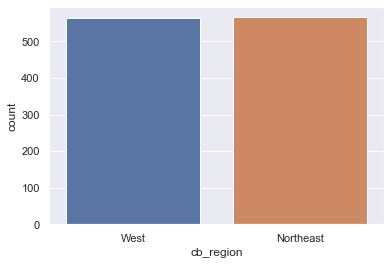

In [52]:
sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.cb_region.value_counts()

4.0    735
2.0    394
Name: institution_level, dtype: int64

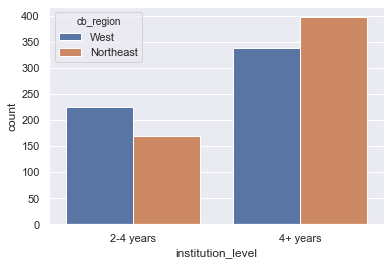

In [53]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'institution_level', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ax.set_xticklabels(['2-4 years', '4+ years']);
ipeds_new_df.institution_level.value_counts()

1.0    571
2.0    391
3.0    167
Name: inst_control, dtype: int64

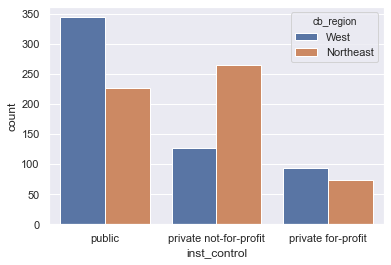

In [54]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_control', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ax.set_xticklabels(['public', 'private not-for-profit', 'private for-profit']);
ipeds_new_df.inst_control.value_counts()

2.0    604
4.0    394
3.0    130
1.0      1
Name: inst_category, dtype: int64

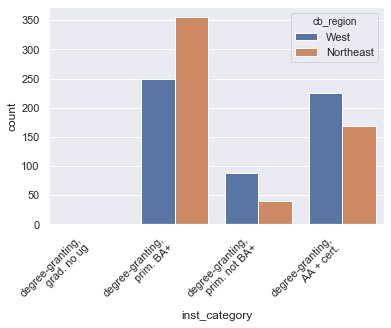

In [56]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_category', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ax.set_xticklabels(['degree-granting,\n grad. no ug', 
                    'degree-granting,\n prim. BA+', 'degree-granting,\n prim. not BA+', 
                    'degree-granting,\n AA + cert.'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_new_df.inst_category.value_counts()

2.0    410
1.0    248
3.0    228
4.0    145
5.0     98
Name: inst_size, dtype: int64

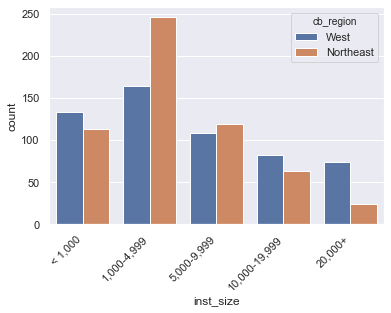

In [57]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_size', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ax.set_xticklabels(['< 1,000', '1,000-4,999', '5,000-9,999', 
                    '10,000-19,999', '20,000+'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_new_df.inst_size.value_counts()

2.0    364
4.0    319
1.0    252
3.0    119
6.0     48
5.0     27
Name: sector, dtype: int64

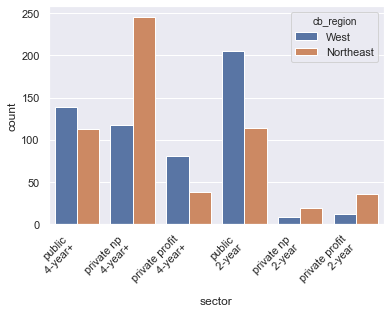

In [58]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'sector', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ax.set_xticklabels(['public\n 4-year+', 'private np\n 4-year+', 
                    'private profit\n 4-year+', 'public\n 2-year', 'private np\n 2-year', 
                    'private profit\n 2-year'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_new_df.sector.value_counts()

0.0    566
1.0    563
Name: tuition_varies, dtype: int64

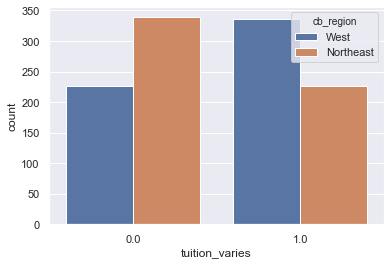

In [60]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'tuition_varies', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.tuition_varies.value_counts()

1.0    689
0.0    440
Name: study_abroad, dtype: int64

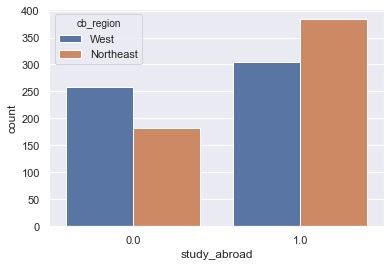

In [91]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'study_abroad', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.study_abroad.value_counts()

1.0    584
0.0    545
Name: student_veteran_organization, dtype: int64

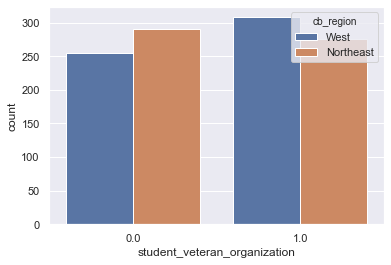

In [92]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'student_veteran_organization', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.student_veteran_organization.value_counts()

1.0    655
0.0    474
Name: yellow_ribbon_program, dtype: int64

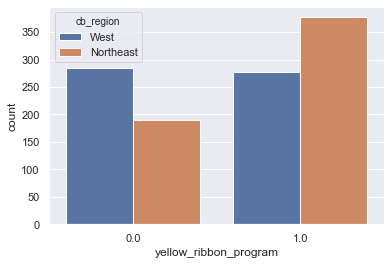

In [93]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'yellow_ribbon_program', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.yellow_ribbon_program.value_counts()

1.0    641
0.0    488
Name: weekend_evening_college, dtype: int64

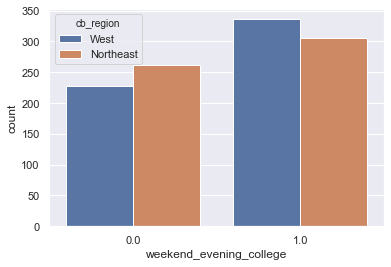

In [94]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'weekend_evening_college', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.weekend_evening_college.value_counts()

1.0    624
0.0    505
Name: oncampus_housing, dtype: int64

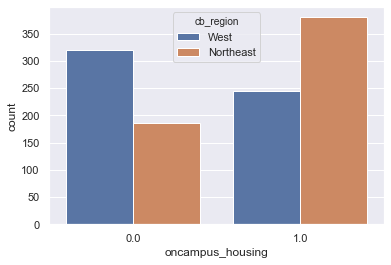

In [95]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'oncampus_housing', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.oncampus_housing.value_counts()

0.0    767
1.0    362
Name: rotc, dtype: int64

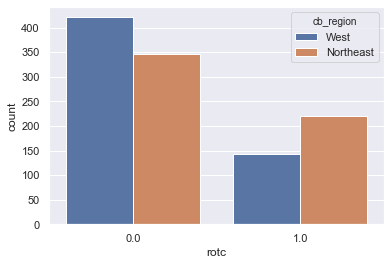

In [96]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'rotc', hue = 'cb_region', data = ipeds_new_df, ax = ax)
ipeds_new_df.rotc.value_counts()

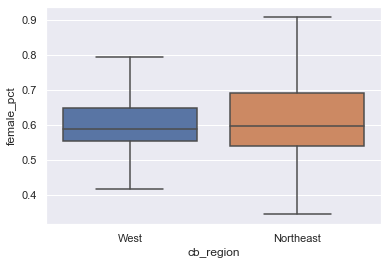

In [97]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'female_pct', 
            data = ipeds_new_df, ax = ax, showfliers = False)

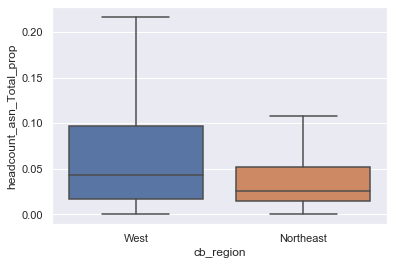

In [62]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_asn_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

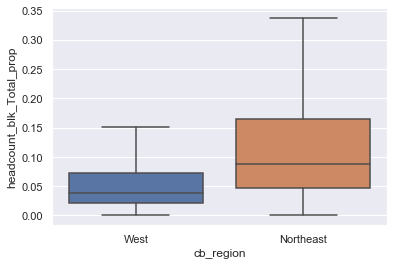

In [63]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_blk_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

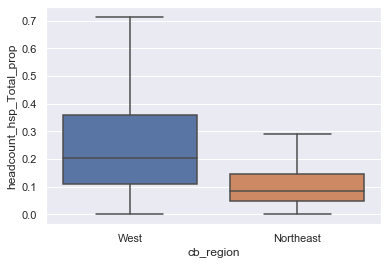

In [65]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hsp_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

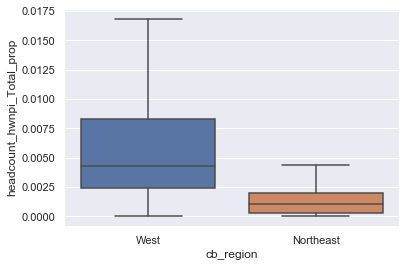

In [66]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hwnpi_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

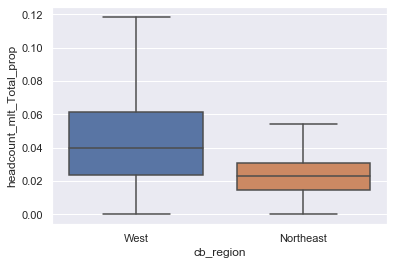

In [68]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_mlt_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

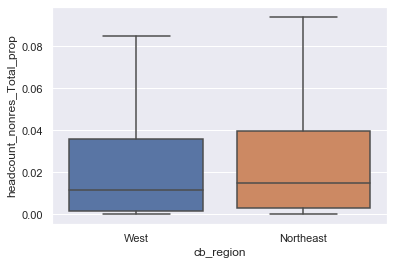

In [69]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_nonres_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

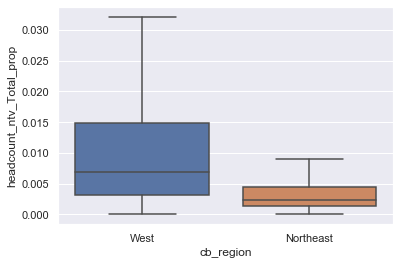

In [70]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_ntv_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

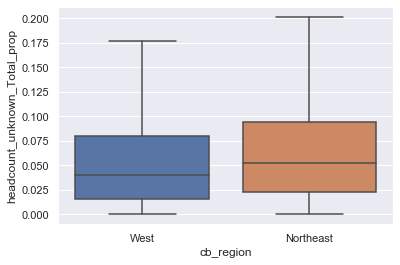

In [71]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_unknown_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

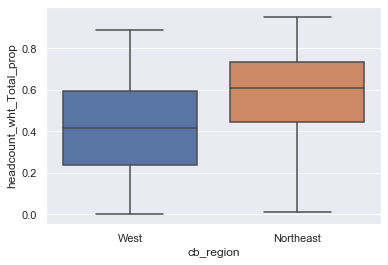

In [72]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_wht_Total_prop', 
            data = ipeds_new_df, ax = ax, showfliers = False)

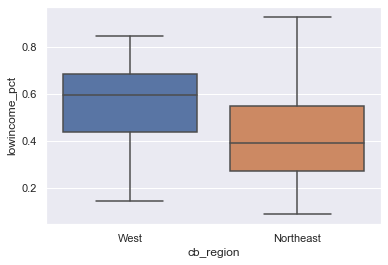

In [73]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'lowincome_pct', 
            data = ipeds_new_df, ax = ax)

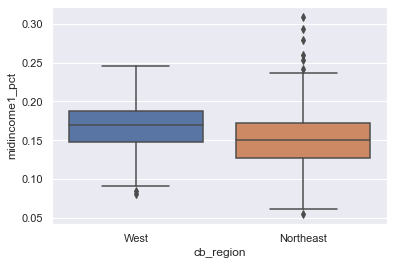

In [77]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'midincome1_pct', 
            data = ipeds_new_df, ax = ax)

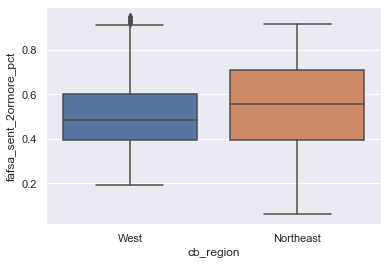

In [79]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'fafsa_sent_2ormore_pct', 
            data = ipeds_new_df, ax = ax)

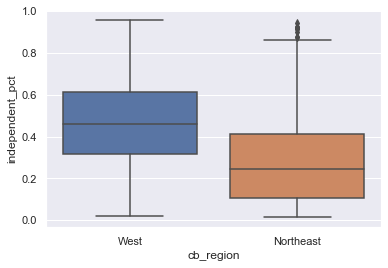

In [81]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'independent_pct', 
            data = ipeds_new_df, ax = ax)

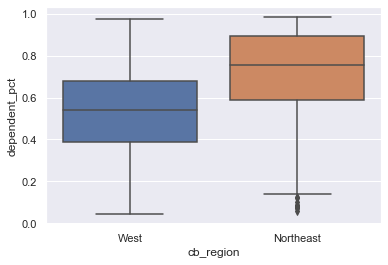

In [82]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'dependent_pct', 
            data = ipeds_new_df, ax = ax)

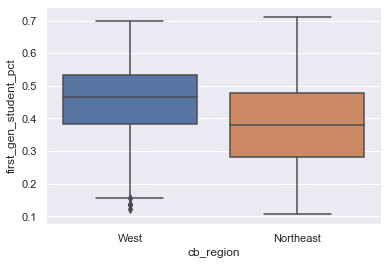

In [83]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'first_gen_student_pct', 
            data = ipeds_new_df, ax = ax)

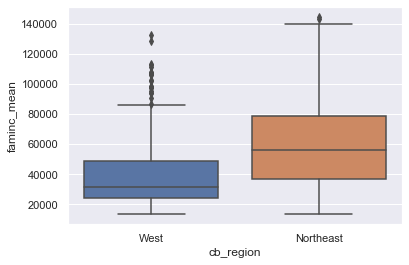

In [84]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'faminc_mean', 
            data = ipeds_new_df, ax = ax)

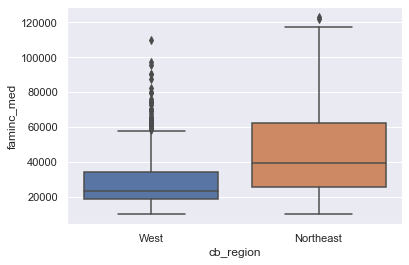

In [85]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'faminc_med', 
            data = ipeds_new_df, ax = ax)

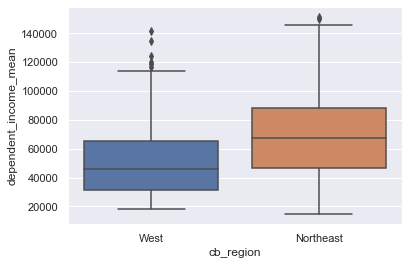

In [98]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'dependent_income_mean', 
            data = ipeds_new_df, ax = ax)

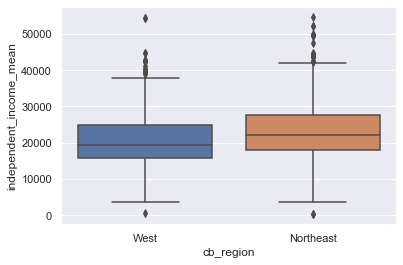

In [99]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'independent_income_mean', 
            data = ipeds_new_df, ax = ax)

In [80]:
ipeds_new_df.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari